**Load libraries**

In [1]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from google.colab.patches import cv2_imshow

import cv2
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix,classification_report

**Mount google drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Load images,labels and print the shape of dataset**

In [4]:
images = np.load('/content/drive/MyDrive/images.npy', mmap_mode='r+')

In [5]:
images.shape

(4750, 128, 128, 3)

There are 4750 images of 128x128 pixels in RGB scale.

In [6]:
imageLabels = pd.read_csv('/content/drive/MyDrive/Labels.csv')

In [7]:
imageLabels.head()

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill


In [8]:
imageLabels.shape

(4750, 1)

In [9]:
imageLabels.nunique()

Label    12
dtype: int64

There are 12 unique labels.

In [10]:
imageLabels['Label'].unique()

array(['Small-flowered Cranesbill', 'Fat Hen', 'Shepherds Purse',
       'Common wheat', 'Common Chickweed', 'Charlock', 'Cleavers',
       'Scentless Mayweed', 'Sugar beet', 'Maize', 'Black-grass',
       'Loose Silky-bent'], dtype=object)

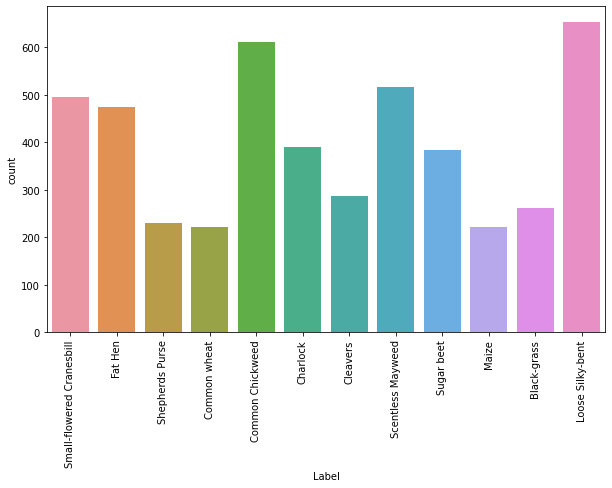

In [11]:
plt.figure(figsize=(10,6))
sns.countplot(imageLabels['Label']);
plt.xticks(rotation = 90);

**Visualize the images**

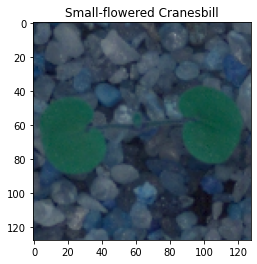

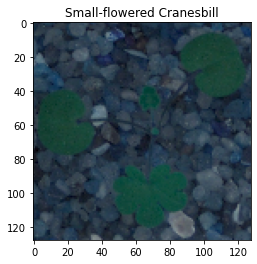

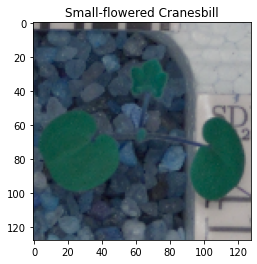

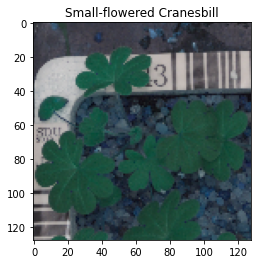

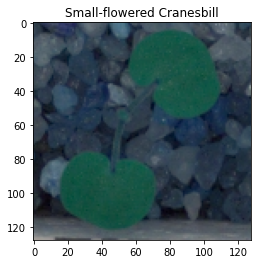

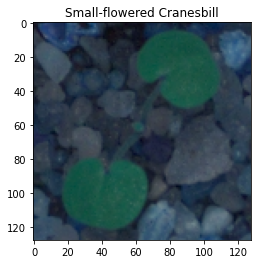

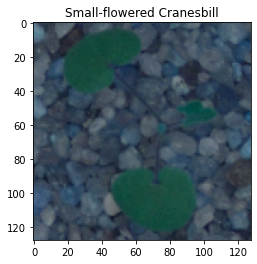

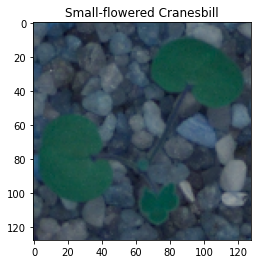

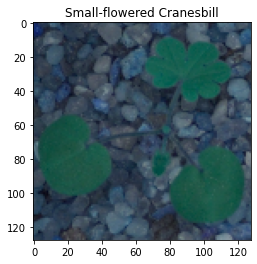

In [12]:
for i in range(9):
  plt.title(imageLabels.at[i,'Label'])
  plt.imshow(images[i])
  plt.show()

**Gaussian Blurring**

In [13]:
imageArr = []
for image in images:
  gaussian_img = cv2.GaussianBlur(image,(5,5),0)
  imageArr.append(gaussian_img)

**Normalization**

In [14]:
imageArr = np.array(imageArr)

In [15]:
imageArr = imageArr.astype('float32')/255.0

In [16]:
type(imageArr)

numpy.ndarray

**Visualize after preprocessing**

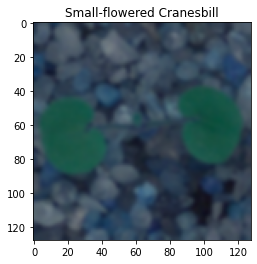

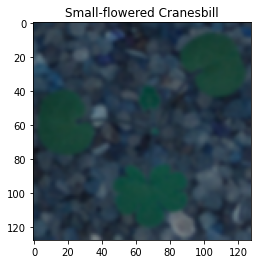

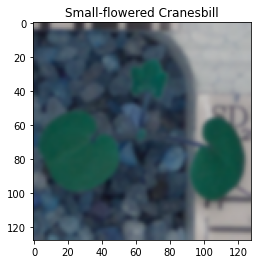

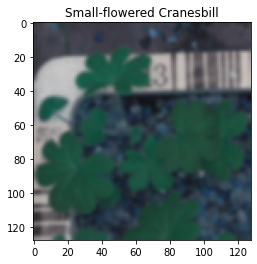

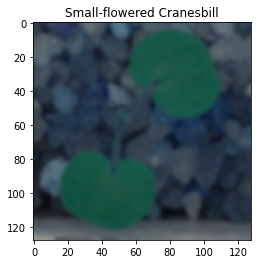

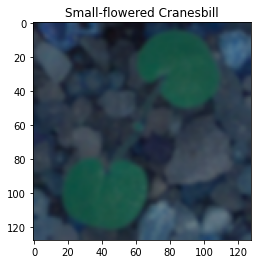

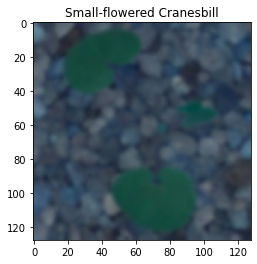

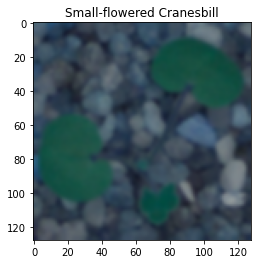

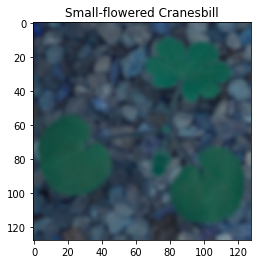

In [17]:
for i in range(9):
  plt.title(imageLabels.at[i,'Label'])
  plt.imshow(imageArr[i])
  plt.show()

In [18]:
X = np.array(imageArr)

**Convert to one hot vectors**

In [19]:
le = LabelEncoder()
y = le.fit_transform(imageLabels)
y = to_categorical(y,12)

In [20]:
type(y)

numpy.ndarray

In [21]:
y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

**Split into train/test/validation sets**

In [22]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=7)
X_val,X_test,y_val,y_test = train_test_split(X_test,y_test,test_size=0.5,random_state=7)

In [23]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(3325, 128, 128, 3)
(713, 128, 128, 3)
(712, 128, 128, 3)
(3325, 12)
(713, 12)
(712, 12)


Input is already in desired shape.

In [24]:
y_train[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

**Data Augmentation to reduce overfitting**

In [25]:
from keras.preprocessing.image import ImageDataGenerator

In [95]:
train_datagen = ImageDataGenerator(
        rotation_range=180,  
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,
        vertical_flip=True)


train_datagen.fit(X_train)

**Build CNN**

In [108]:
model = Sequential()

model.add(Conv2D(64,(3,3),padding='valid',input_shape=(128, 128, 3),activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(128,(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(128,(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(64,(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(64,(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(units=512,activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(units=128,activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(12,activation='softmax'))


In [109]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

**Fit the model**

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [110]:
early_stopping_cb = EarlyStopping(monitor="val_loss", patience=10,min_delta=0.001,
                                  restore_best_weights=True)


model_checkpoint_cb =  ModelCheckpoint('plantSeedlings_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           )

history = model.fit_generator(train_datagen.flow(X_train,y_train,
          batch_size=32),
          epochs=100,
          validation_data=(X_val,y_val),
          steps_per_epoch = len(X_train)/32,
          callbacks=[early_stopping_cb,model_checkpoint_cb])

Epoch 1/100
103/103 [==============================] - 18s 161ms/step - loss: 2.7304 - accuracy: 0.1886 - val_loss: 3.9937 - val_accuracy: 0.1236

Epoch 00001: val_loss improved from inf to 3.99368, saving model to plantSeedlings_cnn_checkpoint_01_loss3.9937.h5
Epoch 2/100
103/103 [==============================] - 17s 160ms/step - loss: 1.7612 - accuracy: 0.4168 - val_loss: 7.8317 - val_accuracy: 0.1320

Epoch 00002: val_loss did not improve from 3.99368
Epoch 3/100
103/103 [==============================] - 17s 160ms/step - loss: 1.4559 - accuracy: 0.5064 - val_loss: 8.2647 - val_accuracy: 0.1320

Epoch 00003: val_loss did not improve from 3.99368
Epoch 4/100
103/103 [==============================] - 16s 158ms/step - loss: 1.2715 - accuracy: 0.5769 - val_loss: 4.4909 - val_accuracy: 0.1742

Epoch 00004: val_loss did not improve from 3.99368
Epoch 5/100
103/103 [==============================] - 16s 158ms/step - loss: 1.0807 - accuracy: 0.6457 - val_loss: 3.3248 - val_accuracy: 0.236

In [121]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 126, 126, 64)      1792      
_________________________________________________________________
batch_normalization_72 (Batc (None, 126, 126, 64)      256       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 124, 124, 128)     73856     
_________________________________________________________________
batch_normalization_73 (Batc (None, 124, 124, 128)     512       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 62, 62, 128)       0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 60, 60, 128)      

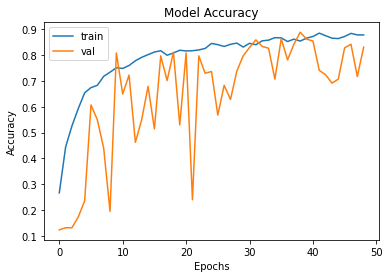

In [111]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

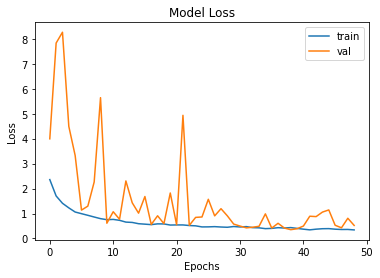

In [112]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

**Evaluate the model**

In [113]:
model.evaluate(X_test, y_test)

23/23 [==============================] - 1s 35ms/step - loss: 0.3113 - accuracy: 0.9032


[0.31127509474754333, 0.9032257795333862]

In [114]:
model.save('/content/drive/MyDrive/Colab Notebooks/PlantSeedlings_model_2_90.3%')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/PlantSeedlings_model_2_90.3%/assets


In [115]:
y_pred = model.predict(X_test) 
y_pred = np.round(y_pred)

In [116]:
y_pred

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [117]:
y_test

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [118]:
print(classification_report(np.argmax(y_test,axis=-1),np.argmax(y_pred,axis=-1)))

              precision    recall  f1-score   support

           0       0.44      0.61      0.51        38
           1       0.94      0.86      0.90        58
           2       0.91      0.89      0.90        47
           3       0.99      0.88      0.93        86
           4       1.00      0.77      0.87        30
           5       0.94      0.98      0.96        87
           6       0.83      0.85      0.84        95
           7       0.92      0.92      0.92        38
           8       0.98      0.93      0.95        86
           9       0.93      0.93      0.93        29
          10       0.98      0.95      0.97        65
          11       0.82      0.94      0.88        54

    accuracy                           0.89       713
   macro avg       0.89      0.88      0.88       713
weighted avg       0.90      0.89      0.89       713



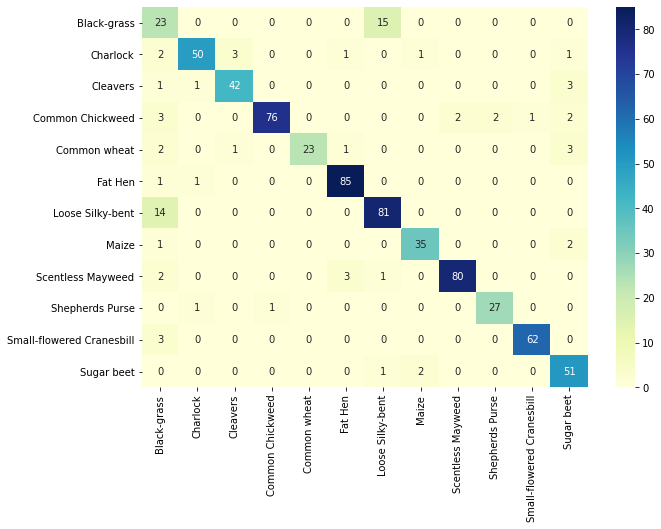

In [119]:
conf = confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1))
conf_df = pd.DataFrame(conf, index = [i for i in le.classes_],
                     columns = [i for i in le.classes_])
conf_df = pd.DataFrame(conf_df)
plt.figure(figsize = (10,7))
sns.heatmap(conf_df, annot=True, fmt='d',cmap='YlGnBu');

**Visualize predictions for x_test[2], x_test[3], x_test[33], x_test[36], x_test[59]**

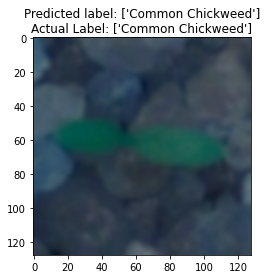

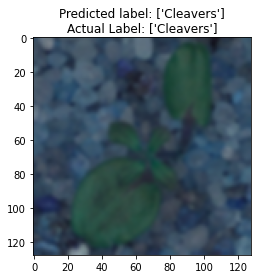

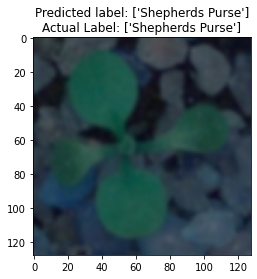

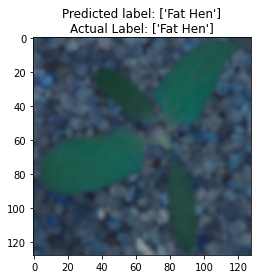

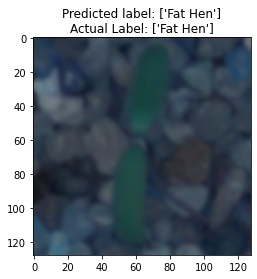

In [120]:
imageIndexList = [2,3,33,36,59]
for i in imageIndexList:
  y_pred = model.predict(X_test[i].reshape(1,128,128,3))
  plt.title("Predicted label: " + str(le.inverse_transform(np.argmax(y_pred,axis=1)))
   + '\n' + "Actual Label: " + str(le.inverse_transform([np.argmax(y_test[i])])))
  plt.imshow(X_test[i])
  plt.show()
  print("====================================")

This model is giving us 90% accuracy on test data.

**Let's try to use Keras tuner to optimize the model.**

In [152]:
def build_model(hp): 

  model = Sequential()

  model.add(Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
                 kernel_size=hp.Choice('conv_1_kernel', values = [3,5])
                 ,padding='valid',input_shape=(128, 128, 3),activation='relu',kernel_initializer='glorot_normal'))
  model.add(BatchNormalization())


  model.add(Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
                 kernel_size=hp.Choice('conv_2_kernel', values = [3,5])
                 ,padding='valid',activation='relu',kernel_initializer='glorot_normal'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2)))
  #model.add(Dropout(0.1))

  model.add(Conv2D(filters=hp.Int('conv_3_filter', min_value=32, max_value=128, step=16),
                 kernel_size=hp.Choice('conv_3_kernel', values = [3,5])
                ,padding='valid',activation='relu',kernel_initializer='glorot_normal'))
  model.add(BatchNormalization())

 
  model.add(Conv2D(filters=hp.Int('conv_4_filter', min_value=32, max_value=128, step=16),
                 kernel_size=hp.Choice('conv_4_kernel', values = [3,5])
                 ,padding='valid',activation='relu',kernel_initializer='glorot_normal'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2)))
  #model.add(Dropout(0.1))

  model.add(Conv2D(filters=hp.Int('conv_5_filter', min_value=32, max_value=128, step=16),
                 kernel_size=hp.Choice('conv_5_kernel', values = [3,5])
                 ,padding='valid',activation='relu',kernel_initializer='glorot_normal'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2)))

  model.add(Conv2D(filters=hp.Int('conv_6_filter', min_value=32, max_value=128, step=16),
                 kernel_size=hp.Choice('conv_6_kernel', values = [3,5])
                ,padding='valid',activation='relu',kernel_initializer='glorot_normal'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2)))
 # model.add(Dropout(0.1))


  model.add(Flatten())
  model.add(Dense(units=hp.Int('dense_1_units', min_value=128, max_value=512, step=16),activation='relu'))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())
  model.add(Dense(units=hp.Int('dense_2_units', min_value=32, max_value=128, step=16),activation='relu'))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())
  model.add(Dense(12,activation='softmax'))
  
  model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [45]:
!pip install keras-tuner

     |████████████████████████████████| 71kB 5.8MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=23fd2d8a5650428bccb985506cf9a5e072f484e71346dd08c8731cc8748256a0
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=5e8e9aab1ba934a31d9e37d1dd2b36b0ecacbb717360231b8871dd58ab11a759
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [46]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [174]:
tuner = RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=5,directory='output3',project_name="PlantSeedlings")

INFO:tensorflow:Reloading Oracle from existing project output3/PlantSeedlings/oracle.json
INFO:tensorflow:Reloading Tuner from output3/PlantSeedlings/tuner0.json


In [175]:
tuner.search(X_train,y_train,epochs=10,validation_data=(X_val,y_val))

INFO:tensorflow:Oracle triggered exit


In [176]:
model_tuned = tuner.get_best_models(num_models=1)[0]

In [177]:
model_tuned.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 112)     3136      
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 112)     448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 112)     313712    
_________________________________________________________________
batch_normalization_1 (Batch (None, 122, 122, 112)     448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 61, 61, 112)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 59, 112)       113008    
_________________________________________________________________
batch_normalization_2 (Batch (None, 59, 59, 112)       4

In [178]:
tuner.results_summary()

Results summary
Results in output3/PlantSeedlings
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
conv_1_filter: 112
conv_1_kernel: 3
conv_2_filter: 112
conv_2_kernel: 5
conv_3_filter: 112
conv_3_kernel: 3
conv_4_filter: 96
conv_4_kernel: 3
conv_5_filter: 112
conv_5_kernel: 3
conv_6_filter: 112
conv_6_kernel: 5
dense_1_units: 384
dense_2_units: 48
Score: 0.7724719047546387
Trial summary
Hyperparameters:
conv_1_filter: 112
conv_1_kernel: 3
conv_2_filter: 96
conv_2_kernel: 3
conv_3_filter: 48
conv_3_kernel: 5
conv_4_filter: 112
conv_4_kernel: 5
conv_5_filter: 80
conv_5_kernel: 3
conv_6_filter: 112
conv_6_kernel: 5
dense_1_units: 224
dense_2_units: 96
Score: 0.7612359523773193
Trial summary
Hyperparameters:
conv_1_filter: 96
conv_1_kernel: 5
conv_2_filter: 112
conv_2_kernel: 3
conv_3_filter: 64
conv_3_kernel: 3
conv_4_filter: 64
conv_4_kernel: 3
conv_5_filter: 96
conv_5_kernel: 5
conv_6_filter: 80
conv_6_kernel: 5
dense_1_units: 256
de

In [179]:
early_stopping_cb = EarlyStopping(monitor="val_loss", patience=18,min_delta=0.001,
                                  restore_best_weights=True)


In [180]:

history = model_tuned.fit_generator(train_datagen.flow(X_train,y_train,
          batch_size=32),
          epochs=100,
          validation_data=(X_val,y_val),
          steps_per_epoch = len(X_train)/32,
          initial_epoch=10,
          callbacks=[early_stopping_cb])

Epoch 11/100
103/103 [==============================] - 20s 178ms/step - loss: 1.1077 - accuracy: 0.6501 - val_loss: 1.3717 - val_accuracy: 0.5829
Epoch 12/100
103/103 [==============================] - 18s 175ms/step - loss: 0.9916 - accuracy: 0.6837 - val_loss: 1.8449 - val_accuracy: 0.4537
Epoch 13/100
103/103 [==============================] - 18s 174ms/step - loss: 0.8976 - accuracy: 0.7171 - val_loss: 2.1657 - val_accuracy: 0.3904
Epoch 14/100
103/103 [==============================] - 18s 175ms/step - loss: 0.8585 - accuracy: 0.7287 - val_loss: 1.2682 - val_accuracy: 0.5927
Epoch 15/100
103/103 [==============================] - 19s 178ms/step - loss: 0.8231 - accuracy: 0.7385 - val_loss: 0.8327 - val_accuracy: 0.7079
Epoch 16/100
103/103 [==============================] - 18s 176ms/step - loss: 0.8159 - accuracy: 0.7389 - val_loss: 0.9758 - val_accuracy: 0.6742
Epoch 17/100
103/103 [==============================] - 18s 175ms/step - loss: 0.7402 - accuracy: 0.7639 - val_loss: 1

In [181]:
model_tuned.evaluate(X_test, y_test)

23/23 [==============================] - 1s 44ms/step - loss: 0.2444 - accuracy: 0.9229


[0.24440661072731018, 0.9228611588478088]

In [182]:
model_tuned.save('/content/drive/MyDrive/Colab Notebooks/PlantSeedlings_tuned_model_3_92.2%')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/PlantSeedlings_tuned_model_3_92.2%/assets


In [183]:
y_pred = model_tuned.predict(X_test) 
y_pred = np.round(y_pred)

In [184]:
print(classification_report(np.argmax(y_test,axis=-1),np.argmax(y_pred,axis=-1)))

              precision    recall  f1-score   support

           0       0.55      0.45      0.49        38
           1       0.96      0.91      0.94        58
           2       0.92      0.96      0.94        47
           3       0.99      0.98      0.98        86
           4       1.00      0.67      0.80        30
           5       0.99      0.99      0.99        87
           6       0.77      0.94      0.85        95
           7       0.97      0.95      0.96        38
           8       0.96      0.93      0.95        86
           9       0.97      1.00      0.98        29
          10       1.00      0.98      0.99        65
          11       0.91      0.96      0.94        54

    accuracy                           0.92       713
   macro avg       0.92      0.89      0.90       713
weighted avg       0.92      0.92      0.92       713



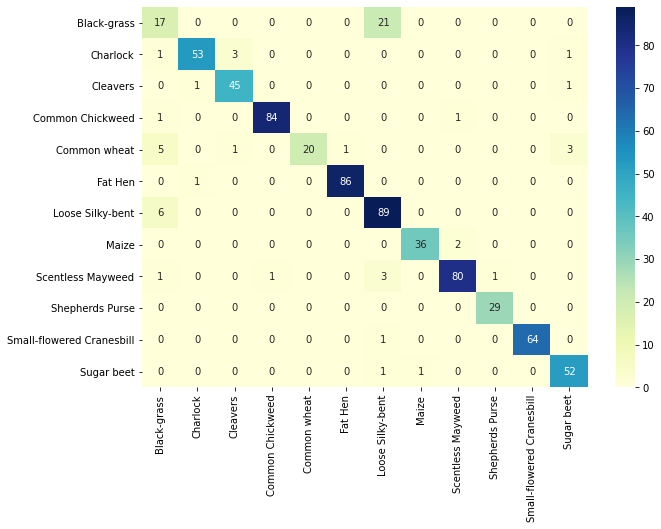

In [185]:
conf = confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1))
conf_df = pd.DataFrame(conf, index = [i for i in le.classes_],
                     columns = [i for i in le.classes_])
conf_df = pd.DataFrame(conf_df)
plt.figure(figsize = (10,7))
sns.heatmap(conf_df, annot=True, fmt='d',cmap='YlGnBu');

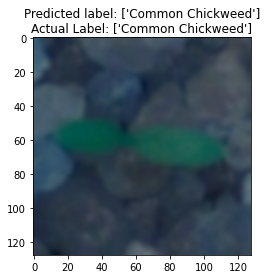

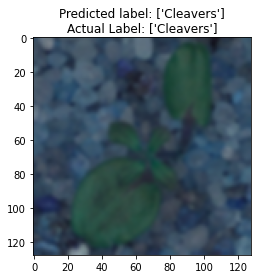

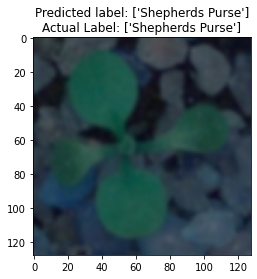

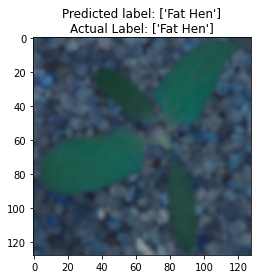

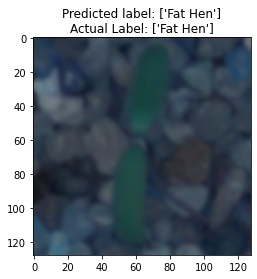

In [186]:
imageIndexList = [2,3,33,36,59]
for i in imageIndexList:
  y_pred = model_tuned.predict(X_test[i].reshape(1,128,128,3))
  plt.title("Predicted label: " + str(le.inverse_transform(np.argmax(y_pred,axis=1)))
   + '\n' + "Actual Label: " + str(le.inverse_transform([np.argmax(y_test[i])])))
  plt.imshow(X_test[i])
  plt.show()
  print("====================================")

This model tuned with keras is giving 92% accuracy on test set.